In [18]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import pickle

import mountain
import gymnasium

from copy import deepcopy

# Part 2 - Report

### Exercise 5

Let's load the trajectories and perform Monte Carlo evaluation to find $v_\pi(s)$ and $q_\pi(a, s)$.

In [19]:
# Load the trajectories
f = open("trajectories.pickle", "rb")
trajectories = pickle.load(f)
f.close()

In [20]:
print(trajectories[0][:5])

[((15, 0), 0, -0.5058824, (14, 0)), ((14, 0), 6, -0.5058824, (14, 0)), ((14, 0), 5, -0.5058824, (15, 1)), ((15, 1), 3, -0.5058824, (16, 0)), ((16, 0), 3, -0.5058824, (17, 0))]


In [21]:
# Store v_π and q_π in respective arrays
rows, columns = 32, 100
v_π = np.array([[0 for _ in range(columns)] for _ in range(rows)])
q_π = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])

# Let's choose a discount factor gamma of 0.99
gamma = 0.99

# Store number of times trajectories go through each state
N_s = np.zeros_like(v_π)
N_as = np.zeros_like(q_π)

# Compute these respective values from the given trajectories
for trajectory in trajectories:
    # Iterate trajectory back-to-front
    G_τ = 0
    for start_state, action, reward, end_state in reversed(trajectory):
        N_s[start_state] += 1
        N_as[start_state][action] += 1

        G_τ = reward + gamma * G_τ
        v_π[start_state] += (G_τ - v_π[start_state]) / N_s[start_state]
        q_π[start_state][action] += (G_τ - q_π[start_state][action]) / N_as[start_state][action]

Let's now plot the state-value function $v_\pi(s)$.

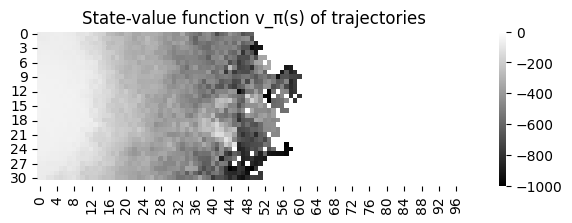

In [22]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(v_π, cmap="gray")
plt.title("State-value function v_π(s) of trajectories")
plt.show()

------------------------------------------
### 4. (*)

We can see that no trajectory got more than halfway down the mountain. As every value on the right is 0, it indicates they are unexplored. This will be a problem as we can not compute an evaluation for the whole map, meaning we again can not calculate an optimal policy for the whole map.

------------------------------------------

------------------------------------------
### 5. (*)

Yes we can perform MC improvement, as the only thing we need for that is the state-action evaluation $q_\pi(a, s)$, which we computed above. However, the new policy cannot possibly be optimal as we have not explored enough of the map. 

------------------------------------------

------------------------------------------
### 6. (*)

No. To do MC control we need a way to generate new trajectories, which we cannot do here.

------------------------------------------

------------------------------------------
### 7. (*)

We already have computed the state-action evaluation $q_\pi(a, s)$ from the same environment as the one we've been given. However, as that evaluation is incomplete (only reached halfway) there would be no gain from using it to initialize our policy. That is because, as no trajectory reached the end, all routes will become more and more negative the further down the map we come. And thus, using this as out starting point will lead to our policy wanting to move left, back towards the start (as here, the values are less negative).

Therefore, it would be best to randomize the starting policy π and "restart".

------------------------------------------

Let's create this policy, aswell as instantiate and run the simulator for the environment through gymnasium.

In [23]:
# Instantiate the environment
env = gymnasium.make('mountain/GridWorld-v0')

In [24]:
# Create the policy
π = np.ones_like(v_π)

for row in range(rows):
    for column in range(columns):
        # Randomize starting policy
        π[row, column] = np.random.randint(8)

We can now perform MC control and learn the optimal policy for the robot through $\epsilon$-greedy.

In [25]:
# For ε-greedy, set epsilon to 0.8 and alpha to 0.99
epsilon = 0.8
alpha = 0.99

# Store evaluation
v_π = np.array([[0 for _ in range(columns)] for _ in range(rows)])
q_π = np.array([[[-1e6 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
N_s = np.zeros_like(v_π)
N_as = np.zeros_like(q_π)

# Store copy to know when policy converges
π_copy = np.zeros_like(π)

# Perform MC ε-greedy control algorithm
iterations = 0
while np.any(π != π_copy):
    iterations += 1
    π_copy = deepcopy(π)

    # First generate a trajectory
    trajectory = []
    observation, info = env.reset()
    terminated = truncated = False
    while not (terminated or truncated):
        state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        action = π[state]
        observation, reward, terminated, truncated, info = env.step(action)

        end_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        trajectory.append((state, action, reward, end_state))
    
    # Then update q_π using MC prediction
    G_τ = 0
    for start_state, action, reward, end_state in reversed(trajectory):
        N_s[start_state] += 1
        N_as[start_state][action] += 1

        G_τ = reward + gamma * G_τ
        v_π[start_state] += (G_τ - v_π[start_state]) / N_s[start_state]
        q_π[start_state][action] += (G_τ - q_π[start_state][action]) / N_as[start_state][action]

    # At last, perform ε-greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π[row, column] = np.argmax(q_π[row, column])
            else:
                π[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha

env.close()
print("Policy π converged after", iterations, "iterations.")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the 

Policy π converged after 710 iterations.


Let's visualize the policy and see if we've found an optimal one.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_to_direction to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_to_direction` for environment variables or `env.get_wrapper_attr('action_to_direction')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.MAP to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.MAP` for environment variables or `env.get_wrapper_attr('MAP')` that will search the reminding wrappers.
  logger.warn(


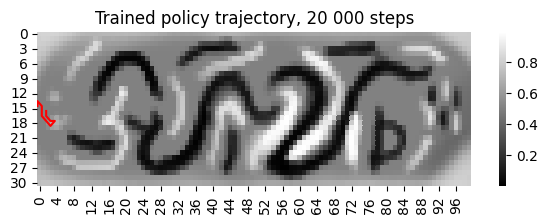

In [28]:
trajectory = [(15, 0)]
for i in range(20000):
    row, column = trajectory[i]
    action = π[row, column]
    direction = env.action_to_direction[action]
    new_row, new_column = row + direction[0], column + direction[1]
    trajectory.append((new_row, new_column))

# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(env.MAP, cmap="gray")
plt.plot(np.array(trajectory)[:, 1], np.array(trajectory)[:, 0], c="r")
plt.title("Trained policy trajectory, 20 000 steps")
plt.show()

If we visualize the trajectory we can see it spins back and fourth right from the start. Let's visualize the compute state-value evaluation aswell.

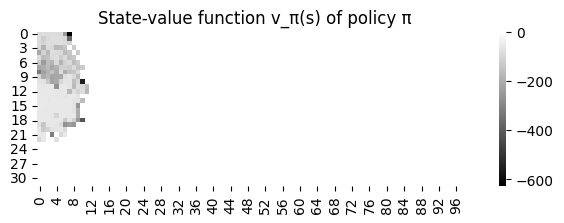

In [27]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(v_π, cmap="gray")
plt.title("State-value function v_π(s) of policy π")
plt.show()

As we can see we have not even explored an eighth of the map!

------------------------------------------
### 9. (*)

No, we did not manage to learn an optimal policy. As we can see from the plot above, we did not even manage to explore an eighth of the map. It is obvious that the challenge with Monte Carlo here is that we never terminate. When performing random moves in an environment as large as this, it is very difficult to reach the end. This will lead to the robot going back and fourth a lot, and thus never exploring further areas.

------------------------------------------